In [3]:
import os
import glob
import numpy as np
import re 

def load_flatpack(k_index, flat_dir="lambda_flat_triplet"):
    path = os.path.join(flat_dir, f"flat_k{k_index:05d}.npz")
    if not os.path.exists(path):
        raise FileNotFoundError(f"Not found: {path}")
    z = np.load(path, allow_pickle=True)
    return {
        "L0flat": z["L0flat"],           
        "L1flat": z["L1flat"],           
        "Eplus_flat":  z["Eplus_flat"], 
        "Eminus_flat": z["Eminus_flat"], 
        "flat_plus_idx":  z["flat_plus_idx"],    
        "flat_minus_idx": z["flat_minus_idx"],  
        "k": z["k"], "k_index": int(z["k_index"])
    }

def flat_BdG(pack, *,DeltaLayer0, DeltaLayer1,mu):
    #
    Δ0 = np.asarray(DeltaLayer0, complex).ravel()
    Δ1 = np.asarray(DeltaLayer1, complex).ravel()
    if Δ0.size != 3 or Δ1.size != 3:
        raise ValueError("DeltaLayer0/1 must each have length 3.")
    # 
    
    Fp = np.diag(np.asarray(pack["Eplus_flat"], float))     # (2,2)
    Fm = -np.diag(np.asarray(pack["Eminus_flat"], float))   # (2,2)

    # 
    L0flat = np.asarray(pack["L0flat"])
    L1flat = np.asarray(pack["L1flat"])
    #
    Gap_flat = sum(Δ0[s] * np.conj(L0flat[s]) + Δ1[s] * np.conj(L1flat[s]) for s in (0,))
    # 
    I = np.eye(Fp.shape[0], dtype=complex)
    HLL = np.block([
        [Fp-mu*I,            Gap_flat        ],
        [Gap_flat.conj().T,   Fm+mu*I        ]
    ]).astype(complex)
    return HLL, Gap_flat


def delta(x,sigma):
    return np.exp(-0.5*(x/sigma)**2) / (np.sqrt(2*np.pi)*sigma)

def thermal_delta(x, T):
    """
    Recommended, numerically stable:  (1/(4T)) * sech^2(x/(2T))
    This equals  -d f_FD(x)/dx  and is always >= 0.
    """
    x = np.asarray(x, dtype=float)
    T = float(T)
    y = x / (2.0*T)
    # sech^2(y) = 1 / cosh(y)^2 is stable even for large |y|
    return (1.0 / (4.0*T)) * (1.0 / np.cosh(y)**2)


def DOS(pack, *, omega,DeltaLayer0, DeltaLayer1,mu):
    #
    HLL, _ = flat_BdG(pack, DeltaLayer0=DeltaLayer0, DeltaLayer1=DeltaLayer1,mu=mu)
    E, U = np.linalg.eigh(HLL)
    # 
    # 
    sigma=2e-5;
    t = delta(omega-E,sigma)  
    G = (U * t) @ U.conj().T                 
    F = np.trace(G[0:2, 0:2] )                                   
    return F

 
def Sum_DOS(*,omega, DeltaLayer0, DeltaLayer1, mu, flat_dir="lambda_flat_singlet", average=True):
    #  
    files = sorted(fn for fn in os.listdir(flat_dir) if re.match(r"flat_k\d{5}\.npz$", fn))
    if not files:
        raise FileNotFoundError(f"No flat_kXXXXX.npz files found in {flat_dir}")
    acc0 = 0j; acc1 = 0j; Nk = 0
    for fn in files:
        pack = load_flatpack(int(fn[6:11]), flat_dir=flat_dir)
        F  = DOS(pack,omega=omega, DeltaLayer0=DeltaLayer0, DeltaLayer1=DeltaLayer1,mu=mu)
        acc0 += F   #
        Nk += 1
    if average and Nk:
        acc0 /= Nk;
    return acc0

In [28]:
###  Case 1.
def DOS(pack, *, omega,DeltaLayer0, DeltaLayer1,mu):
    #
    HLL, _ = flat_BdG(pack, DeltaLayer0=DeltaLayer0, DeltaLayer1=DeltaLayer1,mu=mu)
    E, U = np.linalg.eigh(HLL)
    sigma=5e-5;
    #t = thermal_delta(omega-E,sigma)  
    #sigma=2e-5;
    t = delta(omega-E,sigma)  
    G = (U * t) @ U.conj().T                 
    F = np.trace(G[0:2, 0:2] )                                   
    return F

###
Δ0=+2.090462e-03+5.278279e-06j;
Δ1=-2.090315e-03+5.308632e-06j;
mu=+1.004109e-03

sym=0;
Δ0_vec = np.zeros(3, complex); Δ1_vec = np.zeros(3, complex);
Δ0_vec[sym] = Δ0; Δ1_vec[sym] = Δ1
 
 
omegas = np.linspace(-1e-3, 1e-3, 100)  #  
#  
ReDOS = []
for w in omegas:
    acc0 = Sum_DOS(
        omega=w,
        DeltaLayer0=Δ0_vec,
        DeltaLayer1=Δ1_vec,
        mu=mu,
        flat_dir="lambda_flat_singlet",
        average=True
    )
    ReDOS.append(np.real(acc0))

ReDOS = np.array(ReDOS )


In [120]:

###  
def DOS(pack, *, omega,DeltaLayer0, DeltaLayer1,mu):
    #
    HLL, _ = flat_BdG(pack, DeltaLayer0=DeltaLayer0, DeltaLayer1=DeltaLayer1,mu=mu)
    E, U = np.linalg.eigh(HLL)
    sigma=5e-5;
    #t = thermal_delta(omega-E,sigma)  
    #sigma=2e-5;
    t = delta(omega-E,sigma)  
    G = (U * t) @ U.conj().T                 
    F = np.trace(G[0:2, 0:2] )                                   
    return F

Δ0=+2.532643e-03+6.358490e-06j; 
Δ1=-2.532462e-03+6.349393e-06j;
mu=9.369006e-04; 

sym=0;
Δ0_vec = np.zeros(3, complex); Δ1_vec = np.zeros(3, complex);
Δ0_vec[sym] = Δ0; Δ1_vec[sym] = Δ1
 
 
omegas1 = np.linspace(-1e-3, 1e-3, 100)  # in same units as your Hamiltonian (eV)

# --- evaluate Re[acc0] for each omega using your Sum_DOS ---
ReDOS1 = []
for w in omegas:
    acc0 = Sum_DOS(
        omega=w,
        DeltaLayer0=Δ0_vec,
        DeltaLayer1=Δ1_vec,
        mu=mu,
        flat_dir="lambda_flat_singlet",
        average=True
    )
    ReDOS1.append(np.real(acc0))

ReDOS1 = np.array(ReDOS1 )


In [6]:
def DOS(pack, *, omega,DeltaLayer0, DeltaLayer1,mu):
    #
    HLL, _ = flat_BdG(pack, DeltaLayer0=DeltaLayer0, DeltaLayer1=DeltaLayer1,mu=mu)
    E, U = np.linalg.eigh(HLL)
    #sigma=5e-5;
    #t = thermal_delta(omega-E,sigma)  
    sigma=2e-5;
    t = delta(omega-E,sigma)  
    G = (U * t) @ U.conj().T                 
    F = np.trace(G[0:2, 0:2] )                                   
    return F
### Case 2.
Δ0=+1.580266e-03+4.039947e-06j; 
Δ1=-1.580160e-03+4.042039e-06j; 
mu=+1.075790e-03
###

sym=0;
Δ0_vec = np.zeros(3, complex); Δ1_vec = np.zeros(3, complex);
Δ0_vec[sym] = Δ0; Δ1_vec[sym] = Δ1
 
# --- omega grid ---
omegas2 = np.linspace(-5e-4, 5e-4, 100)  # in same units as your Hamiltonian (eV)

# --- evaluate Re[acc0] for each omega using your Sum_DOS ---
ReDOS2 = []
for w in omegas:
    acc0 = Sum_DOS(
        omega=w,
        DeltaLayer0=Δ0_vec,
        DeltaLayer1=Δ1_vec,
        mu=mu,
        flat_dir="lambda_flat_singlet",
        average=True
    )
    ReDOS2.append(np.real(acc0))

ReDOS2 = np.array(ReDOS2)

In [7]:
### Case 3.
def DOS(pack, *, omega,DeltaLayer0, DeltaLayer1,mu):
    #
    HLL, _ = flat_BdG(pack, DeltaLayer0=DeltaLayer0, DeltaLayer1=DeltaLayer1,mu=mu)
    E, U = np.linalg.eigh(HLL)
    #sigma=5e-5;
    #t = thermal_delta(omega-E,sigma)  
    sigma=2e-5;
    t = delta(omega-E,sigma)  
    G = (U * t) @ U.conj().T                 
    F = np.trace(G[0:2, 0:2] )                                   
    return F
Δ0=+1.332434e-03+3.414211e-06j; 
Δ1=-1.332349e-03+3.461784e-06j;
mu=+1.106836e-03;

sym=0;
Δ0_vec = np.zeros(3, complex); Δ1_vec = np.zeros(3, complex);
Δ0_vec[sym] = Δ0; Δ1_vec[sym] = Δ1
  
# --- omega grid ---
omegas3 = np.linspace(-4e-4, 4e-4, 100)  # in same units as your Hamiltonian (eV)

# --- evaluate Re[acc0] for each omega using your Sum_DOS ---
ReDOS3 = []
for w in omegas:
    acc0 = Sum_DOS(
        omega=w,
        DeltaLayer0=Δ0_vec,
        DeltaLayer1=Δ1_vec,
        mu=mu,
        flat_dir="lambda_flat_singlet",
        average=True
    )
    ReDOS3.append(np.real(acc0))
ReDOS3 = np.array(ReDOS3)

In [142]:
### case 4

def DOS(pack, *, omega,DeltaLayer0, DeltaLayer1,mu):
    #
    HLL, _ = flat_BdG(pack, DeltaLayer0=DeltaLayer0, DeltaLayer1=DeltaLayer1,mu=mu)
    E, U = np.linalg.eigh(HLL)
    #sigma=5e-5;
    #t = thermal_delta(omega-E,sigma)  
    sigma=1e-5;
    t = delta(omega-E,sigma)  
    G = (U * t) @ U.conj().T                 
    F = np.trace(G[0:2, 0:2] )                                   
    return F

Δ0=+1.187420e-03+2.675820e-06j;
Δ1=-1.187327e-03+2.738146e-06j;
mu=+1.122022e-03; 

sym=0;
Δ0_vec = np.zeros(3, complex); Δ1_vec = np.zeros(3, complex);
Δ0_vec[sym] = Δ0; 
Δ1_vec[sym] = Δ1;
 
 
# --- omega grid ---
omegas4 = np.linspace(-2e-4, 2e-4, 100)  # in same units as your Hamiltonian (eV)

# --- evaluate Re[acc0] for each omega using your Sum_DOS ---
ReDOS4 = []
for w in omegas:
    acc0 = Sum_DOS(
        omega=w,
        DeltaLayer0=Δ0_vec,
        DeltaLayer1=Δ1_vec,
        mu=mu,
        flat_dir="lambda_flat_singlet",
        average=True
    )
    ReDOS4.append(np.real(acc0))

ReDOS4 = np.array(ReDOS4)

In [14]:
import numpy as np

def quadratic_piecewise_interp(x, y, m_per_seg=40, ensure_increasing=False, return_coefs=False):
    #
    x = np.asarray(x, float).ravel()
    y = np.asarray(y, float).ravel()
    if x.shape != y.shape:
        raise ValueError("x and y must have the same shape (1D).")

    # Optionally sort and deduplicate
    if ensure_increasing:
        order = np.argsort(x)
        x = x[order]; y = y[order]
        # drop duplicate x
        uniq = np.diff(x) > 0
        if len(x) >= 2:
            keep = np.concatenate(([True], uniq))
            x = x[keep]; y = y[keep]

    # Require strictly increasing x
    if not np.all(np.diff(x) > 0):
        raise ValueError("x must be strictly increasing. "
                         "Use ensure_increasing=True to auto-fix (sort & deduplicate).")

    n = len(x)
    if n < 3:
        raise ValueError("Need at least 3 points for quadratic local fits.")

    # --- fit a quadratic on each interval using 3-point local fits ---
    coefs = []  # per-interval (a,b,c) for y = a*x^2 + b*x + c
    for i in range(n - 1):
        if i == 0:
            idx = [0, 1, 2]
        elif i == n - 2:
            idx = [n - 3, n - 2, n - 1]
        else:
            idx = [i - 1, i, i + 1]
        xi = x[idx]
        yi = y[idx]
        a, b, c = np.polyfit(xi, yi, 2)
        coefs.append((a, b, c))

    # --- evaluate densely for plotting ---
    xx_list, yy_list = [], []
    for i in range(n - 1):
        xi0, xi1 = x[i], x[i + 1]
        a, b, c = coefs[i]
        # Make the very last segment include its endpoint to avoid a gap
        xx = np.linspace(xi0, xi1, int(m_per_seg), endpoint=(i == n - 2))
        yy = a * xx**2 + b * xx + c
        xx_list.append(xx)
        yy_list.append(yy)

    xx1 = np.concatenate(xx_list)
    yy1 = np.concatenate(yy_list)

    if return_coefs:
        return xx1, yy1, coefs
    return xx1, yy1


In [121]:
x = omegas1.astype(float)
y = (ReDOS1*0.2/(2*np.pi)**2).astype(float)
xx0, yy0 = quadratic_piecewise_interp(x, y, m_per_seg=40)
# Example usage with your variables:
x = omegas.astype(float)
y = (ReDOS*0.2/(2*np.pi)**2).astype(float)
xx1, yy1 = quadratic_piecewise_interp(x, y, m_per_seg=40)
#
# Or to retrieve the segment coefficients:
x = omegas2.astype(float)
y = (ReDOS2*0.2/(2*np.pi)**2).astype(float)
xx2, yy2 = quadratic_piecewise_interp(x, y, m_per_seg=40)
#
x = omegas3.astype(float)
y = (ReDOS3*0.2/(2*np.pi)**2).astype(float)
xx3, yy3 = quadratic_piecewise_interp(x, y, m_per_seg=40)
#
x = omegas4.astype(float)
y = (ReDOS4*0.2/(2*np.pi)**2).astype(float)
xx4, yy4 = quadratic_piecewise_interp(x, y, m_per_seg=40)

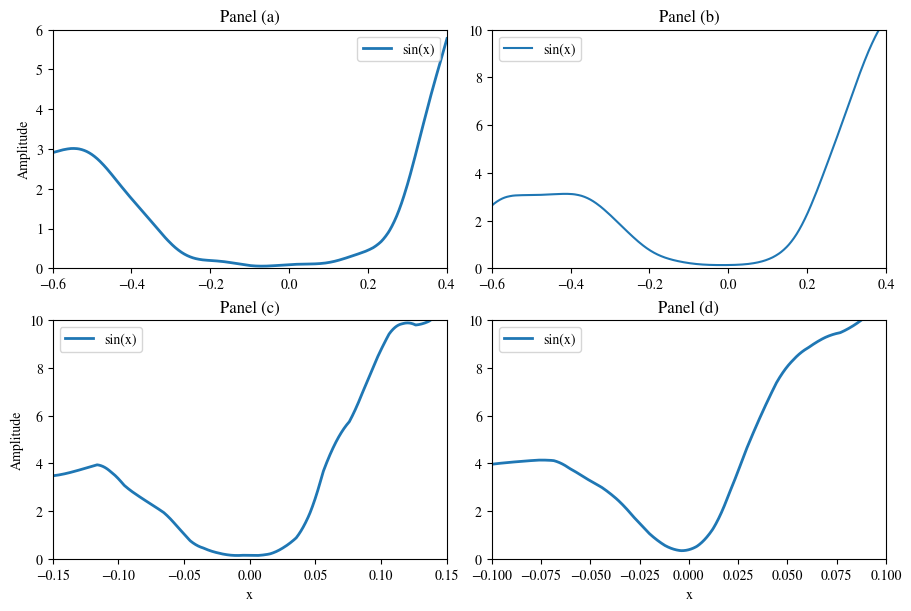

In [122]:
import numpy as np
import matplotlib.pyplot as plt


import matplotlib
matplotlib.rcParams["mathtext.fontset"] = "cm"
matplotlib.rcParams["font.family"] = "STIXGeneral"

fig, axes = plt.subplots(2, 2, figsize=(9, 6), constrained_layout=True)

# Top-left
axes[0, 0].plot(1000*xx0, yy0, label='sin(x)', linewidth=2)
axes[0, 0].set_title('Panel (a)')
axes[0, 0].set_xlim(-0.6,0.4)     
axes[0, 0].set_ylim(0,6)     
axes[0, 0].set_ylabel('Amplitude')
 
axes[0, 0].legend()

# Top-right
axes[0, 1].plot(1000*xx1, yy1, label='sin(x)')

axes[0, 1].set_title('Panel (b)')
#axes[0, 1].set_xlim(2, 8)      # different xlim
axes[0, 1].set_xlim(-0.6,0.4)     
axes[0, 1].set_ylim(0,10) 
axes[0, 1].legend()

# Bottom-left
axes[1, 0].plot(1000*xx2, yy2, label='sin(x)', linewidth=2)

axes[1, 0].set_title('Panel (c)')
#axes[1, 0].set_xlim(0, 6)      # different xlim
axes[1, 0].set_xlabel('x')
axes[1, 0].set_ylabel('Amplitude')

axes[1, 0].set_xlim(-0.15,0.15)     
axes[1, 0].set_ylim(0,10)  

axes[1, 0].legend()

# Bottom-right
axes[1, 1].plot(1000*xx3, yy3, label='sin(x)', linewidth=2)
axes[1, 1].set_title('Panel (d)')
#axes[1, 1].set_xlim(4, 10)     # different xlim
axes[1, 1].set_xlabel('x')

axes[1, 1].set_xlim(-0.1,0.1)     
axes[1, 1].set_ylim(0,10)  


axes[1, 1].legend()

#fig.suptitle('2×2 Subfigures Example', fontsize=14, y=1.02)

#plt.show()

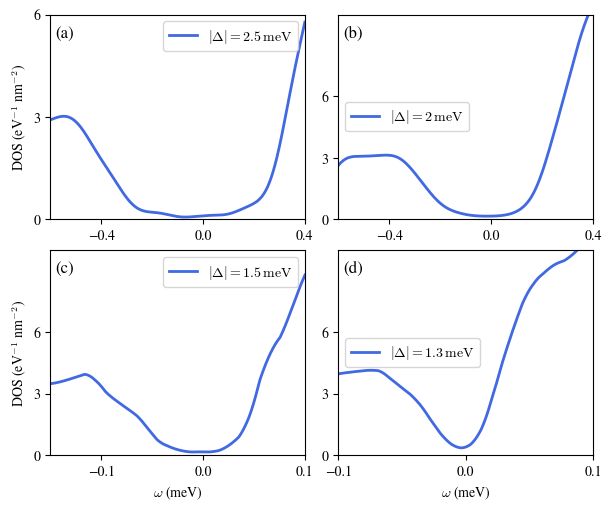

In [91]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(6, 5), constrained_layout=True)

# --- (a) top-left ---
axes[0, 0].plot(1000*xx0, yy0, linewidth=2, label=r"$|\Delta|=2.5\,\mathrm{meV}$",color="royalblue")
axes[0, 0].text(0.02, 0.95, "(a)", transform=axes[0, 0].transAxes,
                ha="left", va="top", fontsize=12)
axes[0, 0].set_xlim(-0.6, 0.4)
axes[0, 0].set_ylim(0, 6)
axes[0, 0].set_xticks([-0.4,0, 0.4])
axes[0, 0].set_yticks([0, 3, 6])
axes[0, 0].set_ylabel(r"DOS (eV$^{-1}$ nm$^{-2}$)")
axes[0, 0].legend()

# --- (b) top-right ---
axes[0, 1].plot(1000*xx1, yy1, linewidth=2, label=r"$|\Delta|=2\,\mathrm{meV}$",color="royalblue")
axes[0, 1].text(0.02, 0.95, "(b)", transform=axes[0, 1].transAxes,
                ha="left", va="top", fontsize=12)
axes[0, 1].set_xlim(-0.6, 0.4)
axes[0, 1].set_ylim(0, 10)
axes[0, 1].set_xticks([-0.4,0, 0.4])
axes[0, 1].set_yticks([0, 3, 6])
axes[0, 1].legend()

# --- (c) bottom-left ---
axes[1, 0].plot(1000*xx2, yy2, linewidth=2, label=r"$|\Delta|=1.5\,\mathrm{meV}$",color="royalblue")
axes[1, 0].text(0.02, 0.95, "(c)", transform=axes[1, 0].transAxes,
                ha="left", va="top", fontsize=12)
axes[1, 0].set_xlim(-0.15, 0.1)
axes[1, 0].set_ylim(0, 10)
axes[1, 0].set_xticks([-0.1,0, 0.1])
axes[1, 0].set_yticks([0, 3, 6])
axes[1, 0].set_xlabel(r"$\omega$ (meV)")
axes[1, 0].set_ylabel(r"DOS (eV$^{-1}$ nm$^{-2}$)")
axes[1, 0].legend()

# --- (d) bottom-right ---
axes[1, 1].plot(1000*xx3, yy3, linewidth=2, label=r"$|\Delta|=1.3\,\mathrm{meV}$",color="royalblue")
axes[1, 1].text(0.02, 0.95, "(d)", transform=axes[1, 1].transAxes,
                ha="left", va="top", fontsize=12)
axes[1, 1].set_xlim(-0.1, 0.1)
axes[1, 1].set_ylim(0, 10)
axes[1, 1].set_xticks([-0.1,0, 0.1])
axes[1, 1].set_yticks([0, 3, 6])
axes[1, 1].set_xlabel(r"$\omega$ (meV)")
axes[1, 1].legend()

plt.savefig("figs/fig6.pdf", bbox_inches="tight")


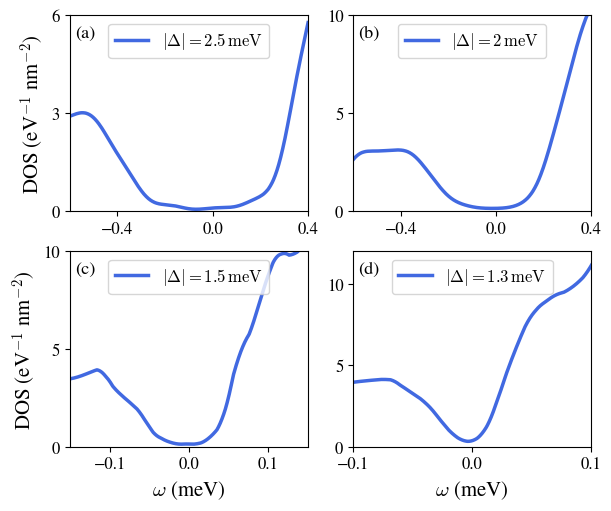

In [106]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(6, 5), constrained_layout=True)


# --- (a) top-left ---
axes[0, 0].plot(1000*xx0, yy0, linewidth=2.5, label=r"$|\Delta|=2.5\,\mathrm{meV}$", color="royalblue")
axes[0, 0].text(0.02, 0.95, "(a)", transform=axes[0, 0].transAxes,
                ha="left", va="top", fontsize=13)
axes[0, 0].set_xlim(-0.6, 0.4)
axes[0, 0].set_ylim(0, 6)
axes[0, 0].set_xticks([-0.4, 0, 0.4])
axes[0, 0].set_yticks([0, 3, 6])  # unchanged
axes[0, 0].set_ylabel(r"DOS (eV$^{-1}$ nm$^{-2}$)", fontsize=15)
axes[0, 0].tick_params(axis='both', labelsize=12)
axes[0, 0].legend(fontsize=12, loc="upper center")

# --- (b) top-right ---
axes[0, 1].plot(1000*xx1, yy1, linewidth=2.5, label=r"$|\Delta|=2\,\mathrm{meV}$", color="royalblue")
axes[0, 1].text(0.02, 0.95, "(b)", transform=axes[0, 1].transAxes,
                ha="left", va="top", fontsize=13)
axes[0, 1].set_xlim(-0.6, 0.4)
axes[0, 1].set_ylim(0, 10)
axes[0, 1].set_xticks([-0.4, 0, 0.4])
axes[0, 1].set_yticks([0, 5, 10])  # changed
axes[0, 1].tick_params(axis='both', labelsize=12)
axes[0, 1].legend(fontsize=12, loc="upper center")

# --- (c) bottom-left ---
axes[1, 0].plot(1000*xx2, yy2, linewidth=2.5, label=r"$|\Delta|=1.5\,\mathrm{meV}$", color="royalblue")
axes[1, 0].text(0.02, 0.95, "(c)", transform=axes[1, 0].transAxes,
                ha="left", va="top", fontsize=13)
axes[1, 0].set_xlim(-0.15, 0.15)
axes[1, 0].set_ylim(0, 10)
axes[1, 0].set_xticks([-0.1, 0, 0.1])
axes[1, 0].set_yticks([0, 5, 10])  # changed
axes[1, 0].set_xlabel(r"$\omega$ (meV)", fontsize=15)
axes[1, 0].set_ylabel(r"DOS (eV$^{-1}$ nm$^{-2}$)", fontsize=15)
axes[1, 0].tick_params(axis='both', labelsize=12)
axes[1, 0].legend(fontsize=12, loc="upper center")

# --- (d) bottom-right ---
axes[1, 1].plot(1000*xx3, yy3, linewidth=2.5, label=r"$|\Delta|=1.3\,\mathrm{meV}$", color="royalblue")
axes[1, 1].text(0.02, 0.95, "(d)", transform=axes[1, 1].transAxes,
                ha="left", va="top", fontsize=13)
axes[1, 1].set_xlim(-0.1, 0.1)
axes[1, 1].set_ylim(0, 12)
axes[1, 1].set_xticks([-0.1, 0, 0.1])
axes[1, 1].set_yticks([0, 5, 10])  # changed
axes[1, 1].set_xlabel(r"$\omega$ (meV)", fontsize=15)
axes[1, 1].tick_params(axis='both', labelsize=12)
axes[1, 1].legend(fontsize=12, loc="upper center")



plt.savefig("figs/fig6.pdf", bbox_inches="tight")


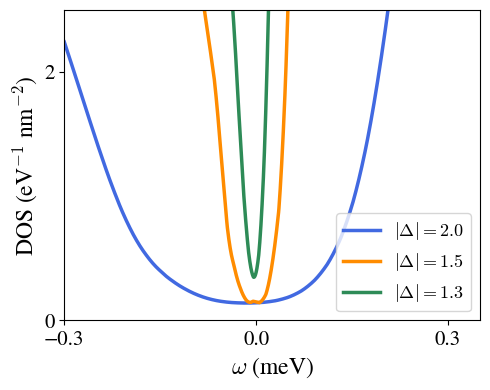

In [146]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 4))

# --- prepare per-curve crops in meV domain and clip y to the old per-panel ylim ---
# (a) x in [-0.6, 0.4] meV, y in [0, 6]
x0 = 1000.0 * xx0
m0 = (x0 >= -0.6) & (x0 <= 0.4)
y0c = np.clip(yy0[m0], 0.0, 6.0)
x0c = x0[m0]

# (b) x in [-0.6, 0.4] meV, y in [0, 10]
x1 = 1000.0 * xx1
m1 = (x1 >= -0.6) & (x1 <= 0.4)
y1c = np.clip(yy1[m1], 0.0, 10.0)
x1c = x1[m1]

# (c) x in [-0.15, 0.1] meV, y in [0, 10]
x2 = 1000.0 * xx2
m2 = (x2 >= -0.15) & (x2 <= 0.10)
y2c = np.clip(yy2[m2], 0.0, 10.0)
x2c = x2[m2]

# (d) x in [-0.1, 0.1] meV, y in [0, 12]
x3 = 1000.0 * xx3
m3 = (x3 >= -0.10) & (x3 <= 0.10)
y3c = np.clip(yy3[m3], 0.0, 12.0)
x3c = x3[m3]

# --- plot (distinct colors) ---
#ax.plot(x0c, y0c, linewidth=2.5, color="royalblue",  label=r"$|\Delta|=2.5\,\mathrm{meV}$")
ax.plot(x1c, y1c, linewidth=2.5, color="royalblue",    label=r"$|\Delta|=2.0$")
ax.plot(x2c, y2c, linewidth=2.5, color="darkorange", label=r"$|\Delta|=1.5$")
ax.plot(x3c, y3c, linewidth=2.5, color="seagreen",   label=r"$|\Delta|=1.3$")

# --- global axes: cover the widest x and the tallest y across panels ---
ax.set_xlim(-0.3, 0.35)
ax.set_ylim(0,2.5)
ax.set_xticks([-0.3, 0.0, 0.3])
ax.set_yticks([0, 2])

# labels & fonts
ax.set_xlabel(r"$\omega$ (meV)", fontsize=17)
ax.set_ylabel(r"DOS (eV$^{-1}$ nm$^{-2}$)", fontsize=17)
ax.tick_params(axis='both', labelsize=15)

# legend (upper center), font size 13
ax.legend(loc="lower right", fontsize=13, ncol=1, frameon=True)

plt.tight_layout()
plt.savefig("figs/fig6.pdf", bbox_inches="tight")



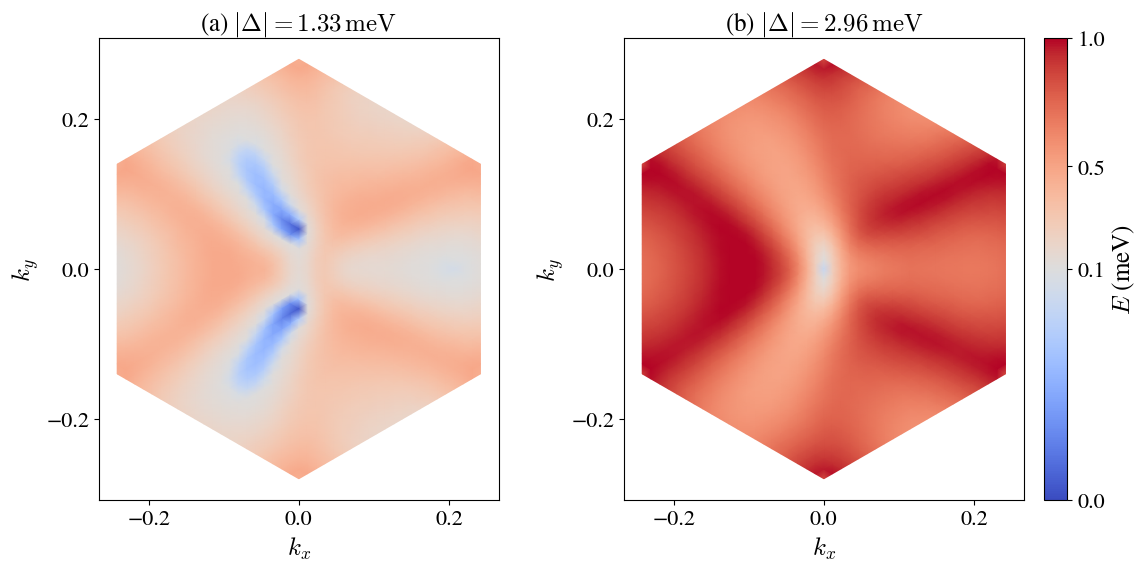

In [177]:
import numpy as np
import os

#### Read

def load_flatpack(k_index, flat_dir="lambda_flat_triplet"):
    path = os.path.join(flat_dir, f"flat_k{k_index:05d}.npz")
    if not os.path.exists(path):
        raise FileNotFoundError(f"Not found: {path}")
    z = np.load(path, allow_pickle=True)
    return {
        "L0flat": z["L0flat"],          # (3,2,2)
        "L1flat": z["L1flat"],          # (3,2,2)
        "Eplus_flat":  z["Eplus_flat"], # (2,)
        "Eminus_flat": z["Eminus_flat"],# (2,)
        "flat_plus_idx":  z["flat_plus_idx"],   # (2,)
        "flat_minus_idx": z["flat_minus_idx"],  # (2,)
        "k": z["k"], "k_index": int(z["k_index"])
    }

def flat_bdg_from_flatpack(pack, *,DeltaLayer0, DeltaLayer1,mu):
    #
    Δ0 = np.asarray(DeltaLayer0, complex).ravel()
    Δ1 = np.asarray(DeltaLayer1, complex).ravel()
    if Δ0.size != 3 or Δ1.size != 3:
        raise ValueError("DeltaLayer0/1 must each have length 3.")
    # 
    
    Fp = np.diag(np.asarray(pack["Eplus_flat"], float))     # (2,2)
    Fm = -np.diag(np.asarray(pack["Eminus_flat"], float))   # (2,2)

    # build 2×2 Gap_flat = V * Σ_s ( Δ0_s Λ0_s^* + Δ1_s Λ1_s^* )
    L0flat = np.asarray(pack["L0flat"])
    L1flat = np.asarray(pack["L1flat"])
    #
    Gap_flat = sum(Δ0[s] * np.conj(L0flat[s]) + Δ1[s] * np.conj(L1flat[s]) for s in (0,))
    ### Only read s=0 channel now.
    I = np.eye(Fp.shape[0], dtype=complex)
    HLL = np.block([
        [Fp-mu*I,            Gap_flat        ],
        [Gap_flat.conj().T,   Fm+mu*I        ]
    ]).astype(complex)
    return HLL, Gap_flat

import os, re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri



def _scan_flat_indices(folder: str):
    """Find flat_kXXXXX.npz files; return sorted list of integer indices."""
    if not os.path.isdir(folder):
        raise FileNotFoundError(f"Directory not found: {folder}")
    pat = re.compile(r"flat_k(\d{5})\.npz$")
    idxs = []
    for name in os.listdir(folder):
        m = pat.match(name)
        if m:
            idxs.append(int(m.group(1)))
    if not idxs:
        raise FileNotFoundError(f"No files matching flat_kXXXXX.npz in {folder}")
    return sorted(idxs)

def collect_bdg_eigs(flat_dir, DeltaLayer0, DeltaLayer1,mu):
    """
    For every flat_kXXXXX.npz in flat_dir:
      - load pack (your load_flatpack),
      - build HLL (your flat_bdg_from_flatpack),
      - eigendecompose (4 eigenvalues).
    Returns: kx (N,), ky (N,), k_index (N,), evals (N,4)
    """
    idxs = _scan_flat_indices(flat_dir)
    kx, ky, k_index, evals = [], [], [], []

    for idx in idxs:
        pack = load_flatpack(idx, flat_dir=flat_dir)  # <-- your function
        HLL, _ = flat_bdg_from_flatpack(              # <-- your function (uses s=0 channel)
            pack, DeltaLayer0=DeltaLayer0, DeltaLayer1=DeltaLayer1,mu=mu
        )
        vals, _ = np.linalg.eigh(HLL)                 # (4,)
        kvec = np.asarray(pack["k"], float).reshape(2,)
        kx.append(kvec[0]); ky.append(kvec[1]); k_index.append(idx)
        evals.append(np.real_if_close(vals))

    return np.array(kx), np.array(ky), np.array(k_index, int), np.vstack(evals)

def plot_eigs_vs_kindex(k_index, evals, *, title, save_png=False, outdir="plots_bdg_eigs"):
    plt.figure()
    for col in range(evals.shape[1]):
        plt.plot(k_index, evals[:, col], label=f"eig {col}",marker="o",linewidth=0,markersize=1)
    plt.xlabel("k_index (path order)")
    plt.ylabel("Eigenvalue")
    plt.title(title)
    plt.legend()
    #plt.ylim([-0.0001,0.0001])
    if save_png:
        os.makedirs(outdir, exist_ok=True)
        plt.savefig(os.path.join(outdir, "eig_vs_kindex.png"), dpi=150, bbox_inches="tight")
    plt.show()

def plot_eigs_on_mesh(kx, ky, evals, *, base_title, save_png=False, outdir="plots_bdg_eigs"):
    tri = mtri.Triangulation(kx, ky)
    for col in [2]:
        plt.figure(figsize=(6,5))
        im = plt.tripcolor(tri, evals[:, col], shading="gouraud")  # smooth coloring
        plt.scatter(kx, ky, s=6, c="k", alpha=0.25)                 # optional markers
        plt.gca().set_aspect("equal", adjustable="box")
        plt.colorbar(im, label="eigenvalue")
        plt.xlabel(r"$k_x$")
        plt.ylabel(r"$k_y$")
        plt.title(f"{base_title} — eigenvalue {col}")
        plt.tight_layout()
        if save_png:
            os.makedirs(outdir, exist_ok=True)
            plt.savefig(os.path.join(outdir, f"eig_{col}_kmap.png"), dpi=200, bbox_inches="tight")
        plt.show()

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from matplotlib.colors import BoundaryNorm, LinearSegmentedColormap, TwoSlopeNorm



import matplotlib
matplotlib.rcParams["mathtext.fontset"] = "cm"
matplotlib.rcParams["font.family"] = "STIXGeneral"

# ---------- segmented colormap: 0–0.1 blue-ish; 0.1–1 yellow→red ----------
def _segmented_cmap_01():
    cdict = {
        "red":   [(0.00, 0.05, 0.05), (0.10, 0.30, 0.95), (1.00, 0.95, 0.95)],
        "green": [(0.00, 0.10, 0.10), (0.10, 0.85, 0.85), (1.00, 0.10, 0.10)],
        "blue":  [(0.00, 0.40, 0.40), (0.10, 0.20, 0.00), (1.00, 0.00, 0.00)],
    }
    return LinearSegmentedColormap("low_high_split_01", cdict)

# ---------- main plotter (row layout) ----------
def plot_absE_norm_split_01_row(
    kxA, kyA, evalsA, ΔA,
    kxB, kyB, evalsB, ΔB,
    *, col=2, meV=True, percentile_ref=99,
    mode="segmented",                    # "segmented" (crisp) or "diverging" (smooth)
    save_png=False, outdir="plots_bdg_eigs", fname="appendixfig2.pdf",
    label_fs=16, tick_fs=14, yticks=(-0.2, 0.0, 0.2)
):
    """
    Same as your column version, but arranged in a 1x2 row layout.
    Plots E (normalized to [0,1]) with a split at 0.1 and a shared colorbar.
    Subtitles show (a/b) and |Δ| in meV. No scatter points or contours.
    """
    triA = mtri.Triangulation(kxA, kyA)
    triB = mtri.Triangulation(kxB, kyB)

    # branch -> meV (if requested)
    scale = 1000.0 if meV else 1.0
    EA = scale * np.asarray(evalsA[:, col], float)
    EB = scale * np.asarray(evalsB[:, col], float)

    # shared robust reference for normalization (kept as in your code)
    A, B = EA, EB  # if you prefer |E|, swap to: A, B = np.abs(EA), np.abs(EB)
    E_ref = np.nanpercentile(np.r_[A, B], percentile_ref)
    if not np.isfinite(E_ref) or E_ref <= 0:
        raise ValueError("Failed to compute a valid E_ref for normalization.")
    NA = np.clip(A / E_ref, 0.0, 1.0)
    NB = np.clip(B / E_ref, 0.0, 1.0)

    # color model (range 0..1; ticks at 0, 0.1, 0.5, 1)
    if mode == "segmented":
        cmap = _segmented_cmap_01()
        bounds = np.r_[np.linspace(0, 0.1, 6), np.linspace(0.15, 1.0, 18)]
        norm = BoundaryNorm(bounds, ncolors=256, clip=True)
    elif mode == "diverging":
        cmap = "coolwarm"
        norm = TwoSlopeNorm(vmin=0.0, vcenter=0.1, vmax=1.0)
    else:
        raise ValueError("mode must be 'segmented' or 'diverging'")

    # --- figure: 1 row x 2 columns (wider canvas) ---
    fig, axes = plt.subplots(1, 2, figsize=(11.6, 5.6), constrained_layout=True)
    axA, axB = axes

    # Panel (a)
    imA = axA.tripcolor(triA, NA, shading="gouraud", cmap=cmap, norm=norm)
    axA.set_aspect("equal", adjustable="box")
    axA.set_xlabel(r"$k_x$", fontsize=label_fs)
    axA.set_ylabel(r"$k_y$", fontsize=label_fs)
    axA.set_yticks(list(yticks))
    axA.tick_params(axis="both", labelsize=tick_fs)
    axA.set_title(fr"(a) $|\Delta|={abs(ΔA)*1000:.2f}\,\mathrm{{meV}}$", fontsize=label_fs)

    # Panel (b)
    imB = axB.tripcolor(triB, NB, shading="gouraud", cmap=cmap, norm=norm)
    axB.set_aspect("equal", adjustable="box")
    axB.set_xlabel(r"$k_x$", fontsize=label_fs)
    axB.set_ylabel(r"$k_y$", fontsize=label_fs)
    axB.set_yticks(list(yticks))
    axB.tick_params(axis="both", labelsize=tick_fs)
    axB.set_title(fr"(b) $|\Delta|={abs(ΔB)*1000:.2f}\,\mathrm{{meV}}$", fontsize=label_fs)

    # shared colorbar on the right; fixed ticks
    cbar = fig.colorbar(imB, ax=axes, location="right", fraction=0.05, pad=0.02)
    cbar.set_label(r"$E$ (meV)", fontsize=label_fs)
    cbar.set_ticks([0, 0.1, 0.5, 1])
    cbar.ax.tick_params(labelsize=tick_fs)

    if save_png:
        os.makedirs(outdir, exist_ok=True)
        fig.savefig(os.path.join(outdir, fname), dpi=240, bbox_inches="tight")
    plt.show()

flat_dir = "lambda_flat_singlet"

# Case A
Δ0A=+1.332434e-03+3.414211e-06j; 
Δ1A=-1.332349e-03+3.461784e-06j;
#mu=+1.106836e-03;
#Δ0A = +1.187420e-03 + 2.675820e-06j
muA = +1.122022e-03
DeltaLayer0A = (Δ0A, 0.0, 0.0)
DeltaLayer1A = (Δ1A, 0.0, 0.0)
kxA, kyA, _, evalsA = collect_bdg_eigs(flat_dir, DeltaLayer0A, DeltaLayer1A, mu=muA)

# Case B
Δ0B=+2.963989e-03+7.460098e-06j; Δ1B=-2.963774e-03+7.472360e-06j;
muB=+8.682626e-04 

#muB = 9.369006e-04
DeltaLayer0B = (Δ0B, 0.0, 0.0)
DeltaLayer1B = (Δ1B, 0.0, 0.0)
kxB, kyB, _, evalsB = collect_bdg_eigs(flat_dir, DeltaLayer0B, DeltaLayer1B, mu=muB)

# Plot (normalized |E|, split at 0.1), no suptitle, no scatter/contours
plot_absE_norm_split_01_row(
    kxA, kyA, evalsA, Δ0A,
    kxB, kyB, evalsB, Δ0B,
    col=2, percentile_ref=99,
    mode="diverging",            # or "diverging" if you prefer smooth
    save_png=True,
    label_fs=18, tick_fs=16,     # larger fonts
    yticks=(-0.2, 0.0, 0.2)      # fixed y-ticks
)

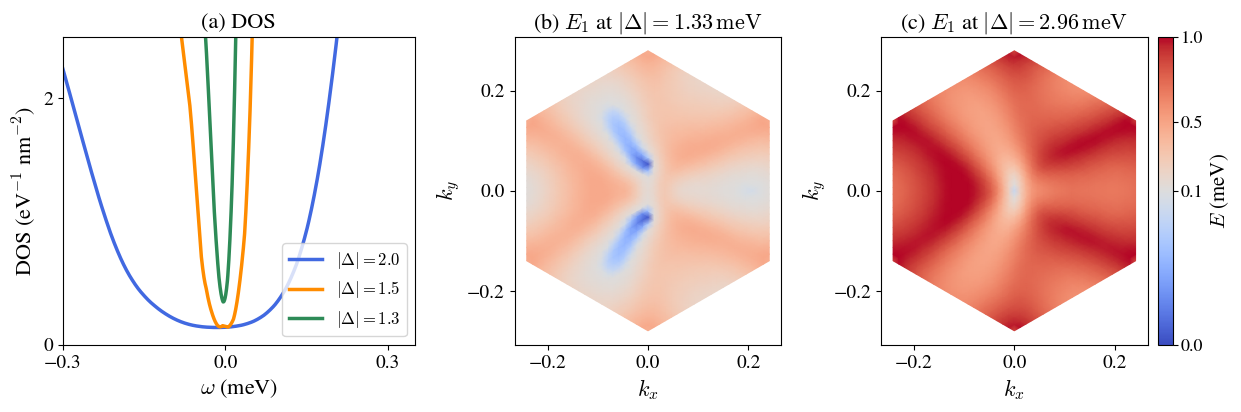

In [214]:
#  
fig, (ax0, ax1, ax2) = plt.subplots(
    1, 3, figsize=(14, 4), # gridspec_kw={'wspace': 0}  # smaller = closer subplots
)

#  
ax0.plot(x1c, y1c, linewidth=2.5, color="royalblue",  label=r"$|\Delta|=2.0$")
ax0.plot(x2c, y2c, linewidth=2.5, color="darkorange", label=r"$|\Delta|=1.5$")
ax0.plot(x3c, y3c, linewidth=2.5, color="seagreen",   label=r"$|\Delta|=1.3$")
ax0.set_xlim(-0.3, 0.35); ax0.set_ylim(0, 2.5)
ax0.set_xticks([-0.3, 0.0, 0.3]); ax0.set_yticks([0, 2])
ax0.set_xlabel(r"$\omega$ (meV)", fontsize=16)
ax0.set_ylabel(r"DOS (eV$^{-1}$ nm$^{-2}$)", fontsize=16)
ax0.tick_params(axis='both', labelsize=14)
ax0.legend(loc="lower right", fontsize=12, frameon=True)
ax0.set_title("(a) DOS", fontsize=16)

#  
im1 = ax1.tripcolor(triA, NA, shading="gouraud", cmap=cmap, norm=norm)
ax1.set_aspect("equal", adjustable="box")
ax1.set_xlabel(r"$k_x$", fontsize=16); ax1.set_ylabel(r"$k_y$", fontsize=16)
ax1.tick_params(axis="both", labelsize=14)
ax1.set_title(fr"(b) $E_1$ at $|\Delta|={abs(Δ0A)*1000:.2f}\,\mathrm{{meV}}$", fontsize=16)
ax1.set_yticks([-0.2,0,0.2])
# 
im2 = ax2.tripcolor(triB, NB, shading="gouraud", cmap=cmap, norm=norm)
ax2.set_aspect("equal", adjustable="box")
ax2.set_xlabel(r"$k_x$", fontsize=16); 
ax2.set_ylabel(r"$k_y$", fontsize=16)
ax2.tick_params(axis="both", labelsize=14)  # <-- fixed: axis not axi
ax2.set_title(fr"(c) $E_1$ at $|\Delta|={abs(Δ0B)*1000:.2f}\,\mathrm{{meV}}$", fontsize=16)
ax2.set_yticks([-0.2,0,0.2])


 
#  
# 
cbar = fig.colorbar(im2, ax=[ax1, ax2], location="right",
                    fraction=0.04, pad=0.02,   # ← increase pad to push bar right
                    anchor=(3, 0.5))         # ← vertical alignment of the bar
cbar.ax.tick_params(labelsize=13, pad=2)       # ← tick-label distance from bar

# 
cbar.set_label(r"$E$ (meV)", fontsize=15)
cbar.set_ticks([0, 0.1, 0.5, 1.0])
cbar.ax.tick_params(labelsize=13)

#  
plt.subplots_adjust(wspace=0.04)

os.makedirs("plots_bdg_eigs", exist_ok=True)
fig.savefig("plots_bdg_eigs/fig6.pdf", dpi=240, bbox_inches="tight")
plt.show()
